In [2]:

import umap

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import adjusted_mutual_info_score as AMI

from scipy import sparse
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
rcParams['figure.figsize'] = (12,12)
import seaborn as sns
from scipy import sparse

sc.settings.verbosity =0

import os
import harmonypy as hm
# import scanorama
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import muon as mu

/home/macera/.conda/envs/scanpy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import matplotlib.patheffects as path_effects

def adjust_labels(coordinates, label_size, scale_factor,categories, max_iterations=5, displacement=1, neighborhood_radius=1.0):
    """
    Adjust label positions to minimize overlaps by moving labels towards areas of lower density.
    Once a label's position is adjusted and it has no overlaps, its position is fixed.

    :param coordinates: numpy array of shape (n_labels, 2) with initial label coordinates.
    :param label_sizes: numpy array of shape (n_labels, 2) with width and height of each label.
    :param scale_factor: scaling factor to adjust label sizes to UMAP coordinate space.
    :param max_iterations: maximum number of iterations for adjustment.
    :param displacement: step size for moving labels.
    :param neighborhood_radius: radius to consider for neighborhood density.
    :return: adjusted coordinates.
    """
    fixed_labels = [False] * len(coordinates)  # Track whether a label's position is fixed

    for _ in range(max_iterations):
        for i in range(len(coordinates)):
            if fixed_labels[i]:
                continue  # Skip this label if its position is already fixed

            direction = np.zeros(2)
            has_overlap = False
            for j in range(len(coordinates)):
                if not fixed_labels[j] and i != j and check_overlap(coordinates[i], coordinates[j],label_size, scale_factor, pad = label_size +20):
                    # print(categories[i],' ', categories[j], 'OVERLAP' )
                    has_overlap = True
                    direction += coordinates[i] - coordinates[j]

            if has_overlap:
                # Normalize and move label
                if np.linalg.norm(direction) != 0:
                    direction /= np.linalg.norm(direction)
                    less_dense_direction = find_less_dense_direction(coordinates, i, neighborhood_radius)
                    direction += less_dense_direction
                    direction /= np.linalg.norm(direction)
                    coordinates[i] += direction * displacement
            else:
                fixed_labels[i] = True  # Mark this label as fixed

        # Check if all labels are fixed, and if so, break the loop
        if all(fixed_labels):
            break

    return coordinates

def check_overlap(coord1, coord2, size, scale_factor=1.0, pad = 25):
    """
    Check if two labels overlap, accounting for scale differences between UMAP coordinates and label sizes.

    :param coord1: coordinates of the first label.
    :param coord2: coordinates of the second label.
    :param size1: size of the first label.
    :param size2: size of the second label.
    :param scale_factor: scaling factor to adjust label sizes to UMAP coordinate space.
    :return: True if labels overlap, False otherwise.
    """
    distance = np.linalg.norm(coord1 - coord2) - pad/scale_factor
    adjusted_size = size / scale_factor
    return distance < adjusted_size

def find_less_dense_direction(coordinates, index, radius):
    """
    Find a direction towards a less dense area for a label.

    :param coordinates: numpy array of label coordinates.
    :param index: index of the label to move.
    :param radius: radius to consider for neighborhood density.
    :return: a unit vector pointing towards a less dense area.
    """
    center = coordinates[index]
    density_vector = np.zeros(2)
    for i, coord in enumerate(coordinates):
        if i != index and np.linalg.norm(coord - center) < radius:
            density_vector += center - coord

    if np.linalg.norm(density_vector) == 0:
        return np.random.rand(2) - 0.5  # Random direction if density is uniform
    else:
        return density_vector / np.linalg.norm(density_vector)
def label_size_to_font_size(label_size):
    # This is a placeholder function. You need to define how to convert label size to font size
    return label_size / 2 

def shorten_line(start, end, shorten_by):
    direction = end - start
    norm_direction = direction / np.linalg.norm(direction)
    return end - norm_direction * shorten_by

# VARIABLES




def umap_refined(adata,
                umap,
                var,
                 size=10,
                label_size = 50,
                width_in_inches = 18,
                height_in_inches = 18,
                max_iterations=20,
                displacement=0.5):
    x_min, y_min = np.min(adata.obsm[umap], axis=0)
    x_max, y_max = np.max(adata.obsm[umap], axis=0)

    umap_width = x_max - x_min
    umap_height = y_max - y_min


    fig = plt.figure(figsize=(width_in_inches, height_in_inches))
    dpi = fig.dpi  # Get the DPI of the figure

    # Convert figure size to pixels
    plot_width_pixels = width_in_inches * dpi
    plot_height_pixels = height_in_inches * dpi

    # You might need to adjust for margins and paddings
    # These are approximate values and might need tweaking
    left_margin = 0.1 * plot_width_pixels
    right_margin = 0.1 * plot_width_pixels
    top_margin = 0.1 * plot_height_pixels
    bottom_margin = 0.1 * plot_height_pixels

    effective_plot_width = plot_width_pixels - (left_margin + right_margin)
    effective_plot_height = plot_height_pixels - (top_margin + bottom_margin)


    scale_factor_x = effective_plot_width / umap_width
    scale_factor_y = effective_plot_height / umap_height

    # Use the smaller scale factor to maintain aspect ratio
    scale_factor = min(scale_factor_x, scale_factor_y)
    print('Figure size=',(width_in_inches, height_in_inches),'dpi=',dpi, 'Scale factor =', scale_factor)

    ax = plt.subplot()
    sc.pl.embedding(adata, basis = umap, color = [var], frameon = False, size = size, show=False, legend_fontoutline=2, ax=ax )


    label_colors = adata.uns[f'{var}_colors']
    # Get initial label positions (centroids of clusters)
    categories = adata.obs[var].cat.categories  # Replace with your category column
    initial_coords = np.array([np.median(adata.obsm[umap][adata.obs[var] == cat], axis=0) for cat in categories])
    # for i in range(len(categories)):
        # print(categories[i], initial_coords[i])
  # Replace with your estimated sizes

    adjusted_coords = adjust_labels(initial_coords.copy(), label_size, scale_factor = scale_factor,categories = categories, max_iterations=2, displacement=0.5)

    scaled_initial_coords = initial_coords 
    scaled_adjusted_coords = adjusted_coords 

    for i, cat in enumerate(categories):
        start_coord = scaled_initial_coords[i]
        end_coord = scaled_adjusted_coords[i]

        # Calculate new endpoint shortened by half the font size
        font_size = label_size_to_font_size(label_size / 2)
        new_end_coord = shorten_line(start_coord, end_coord, font_size/scale_factor)

        # Draw line
        ax.plot([start_coord[0], new_end_coord[0]], 
                [start_coord[1], new_end_coord[1]], 
                color='black', linestyle='-', linewidth=1)

        # Plot label
        text = ax.text(end_coord[0], end_coord[1], cat, 
                       ha='center', va='center', 
                       fontsize=font_size, color=label_colors[i])

        # Add black outline to text
        text.set_path_effects([path_effects.Stroke(linewidth=4, foreground='white'),
                               path_effects.Stroke(linewidth=2, foreground='black'),
                               path_effects.Normal()])
    # Show the plot
    # plt.show()


In [4]:
l1_colors = {
'ATL': '#1f77b4',
  'PT_VCAM1': '#c5b0d5',
 'CNT': '#ff7f0e',
 'DCT': '#279e68',
  'DCT1': '#279e68',
 'DCT2': '#ffb500',
 'DTL': '#d62728',
 'EC': '#aa40fc',
 'ENDO': '#aa40fc',
 'FIB': '#8c564b',
 'IC': '#e377c2',
 'ICA': '#e377c2',
 'ICB': '#7b4f4b',
 'IMM': '#b5bd61',
 'LEUK': '#b5bd61',
 'NEU': '#17becf',
 'PC': '#aec7e8',
 'PEC': '#17becf',
 'POD': '#98df8a',
 'PODO': '#98df8a',
'PT': '#ff9896',
 'PapE': '#c5b0d5',
 'TAL': '#c49c94',
'MES': '#f7b6d2',
 'VSM/P': '#f7b6d2','Unclassified':'#d3d3d3'}

In [5]:
l3_colors = {
'ATL': '#ffff00',
 'B': '#1ce6ff',
 'C-TAL': '#ff34ff',
 'PC': '#aec7e8',
 'CCD-IC-A': '#ff4a46',
 'CCD-PC': '#008941',
 'CNT': '#006fa6',
 'CNT-IC-A': '#a30059',
 'CNT-PC': '#ffdbe5',
 'DCT1': '#7a4900',
 'DCT2': '#0000a6',
 'DTL': '#63ffac',
 'EC-AEA': '#b79762',
 'EC-AVR': '#004d43',
 'EC-DVR': '#8fb0ff',
 'EC-GC': '#997d87',
 'EC-LYM': '#5a0007',
 'EC-PTC': '#809693',
 'FIB': '#6a3a4c',
 'IC-B': '#1b4400',
 'IMCD': '#4fc601',
 'M-FIB': '#3b5dff',
 'M-TAL': '#4a3b53',
 'MAC-M2': '#ff2f80',
 'MAST': '#61615a',
 'MC': '#ba0900',
 'MD': '#6b7900',
 'MDC': '#00c2a0',
 'MYOF': '#ffaa92',
 'N': '#ff90c9',
 'NEU': '#b903aa',
 'NKC/T': '#d16100',
 'OMCD-IC-A': '#ddefff',
 'OMCD-PC': '#000035',
 'PEC': '#7b4f4b',
 'PL': '#a1c299',
 'POD': '#300018',
 'PT-S1/2': '#0aa6d8',
 'PT-S3': '#013349',
 'PapE': '#00846f',
 'REN': '#372101',
 'T': '#ffb500',
 'VSMC': '#c2ffed',
 'VSMC/P': '#a079bf',
 'aFIB': '#cc0744',
 'aPT': '#c0b9b2',
 'aTAL1': '#c2ff99',
 'aTAL2': '#001e09',
 'cDC': '#00489c',
 'cycCNT': '#6f0062',
 'cycDCT': '#0cbd66',
 'cycEC': '#eec3ff',
 'cycMNP': '#456d75',
 'cycMYOF': '#b77b68',
 'cycNKC/T': '#7a87a1',
 'cycPT': '#788d66',
 'dC-IC-A': '#885578',
 'dC-TAL': '#fad09f',
 'dCNT': '#ff8a9a',
 'dDCT': '#d157a0',
 'dEC': '#bec459',
 'dEC-PTC': '#456648',
 'dFIB': '#0086ed',
 'dIMCD': '#886f4c',
 'dM-FIB': '#34362d',
 'dM-TAL': '#b4a8bd',
 'dOMCD-PC': '#00a6aa',
 'dPT': '#452c2c',
 'dVSMC': '#636375',
 'ncMON': '#a3c8c9',
 'pDC': '#ff913f',
 'tPC-IC': '#938a81','Unclassified':'#d3d3d3'}

In [6]:
mdata = mu.read('objects/mdata_final.h5mu')

/home/macera/.conda/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/macera/.conda/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [9]:
from scipy.sparse import csr_matrix

def add_Seurat_WNN(adata, folder = 'csv', save_key = 'Seurat_WNN'):
    obs_names = list(pd.read_csv(f'{folder}/Seurat_WNN_obs_names.csv', sep=';').index)    
    adata = adata[list(obs_names)]
    
    indices_df = pd.read_csv(f'{folder}/{save_key}_idx.csv',sep=';',decimal=',')  # Assuming the CSV files have no header
    distances_df = pd.read_csv(f'{folder}/{save_key}_dist.csv',sep=';',decimal=',')

    # Convert the dataframes to numpy arrays
    indices_array = indices_df.to_numpy() - 1 # We have to correct for index counter pos0=1 ; now p0 = 0
    distances_array = distances_df.to_numpy()

    # Get the shape of the sparse matrix
    n_obs = indices_array.shape[0]  # Number of observations (nodes)
    n_neighbors = indices_array.shape[1]  # Number of nearest neighbors (KNN)

    # Initialize row, col, and data arrays to construct the sparse matrix
    row = np.repeat(np.arange(n_obs), n_neighbors)
    col = indices_array.ravel()
    data = distances_array.ravel().astype(float)

    # Create the sparse matrix
    sparse_matrix = csr_matrix((data, (row, col)), shape=(n_obs, n_obs))

    # Print the sparse matrix (optional)
    adata.obsp[f'distances_{save_key}'] = sparse_matrix
    path = f'{folder}/{save_key}_UMAP.csv'
    if os.path.exists(path):
        adata.obsm[f'Umap_{save_key}'] = pd.read_csv(path,sep=';',decimal=',').to_numpy()
    path = f'{folder}/{save_key}_ATAC_LSI.csv'
    if os.path.exists(path):
        adata.obsm[f'ATAC_LSI_{save_key}'] = pd.read_csv(path,sep=';',decimal=',').to_numpy()
    path = f'{folder}/{save_key}_RNA_SCT_PCA.csv'
    if os.path.exists(path):
        adata.obsm[f'RNA_SCT_PCA_{save_key}'] = pd.read_csv(path,sep=';',decimal=',').to_numpy()
    return adata

In [10]:
mdata = add_Seurat_WNN(mdata, folder = 'csv/custom_WNN')

/tmp/ipykernel_4503/3179136484.py:27: ImplicitModificationWarning: Setting element `.obsp['distances_Seurat_WNN']` of view, initializing view as actual.
  adata.obsp[f'distances_{save_key}'] = sparse_matrix


In [11]:
mdata.obs[['WNN_rna_weights','WNN_atac_weights']] = pd.read_csv('csv/custom_WNN/Seurat_WNN_MOD_WEIGHTS.csv',sep=';', decimal=',')[['RNA.weight','ATAC-weight']]

In [14]:
mdata.write('objects/mdata_final.h5mu', compression='gzip')

Figure size= (14, 14) dpi= 100.0 Scale factor = 49.29339874697772


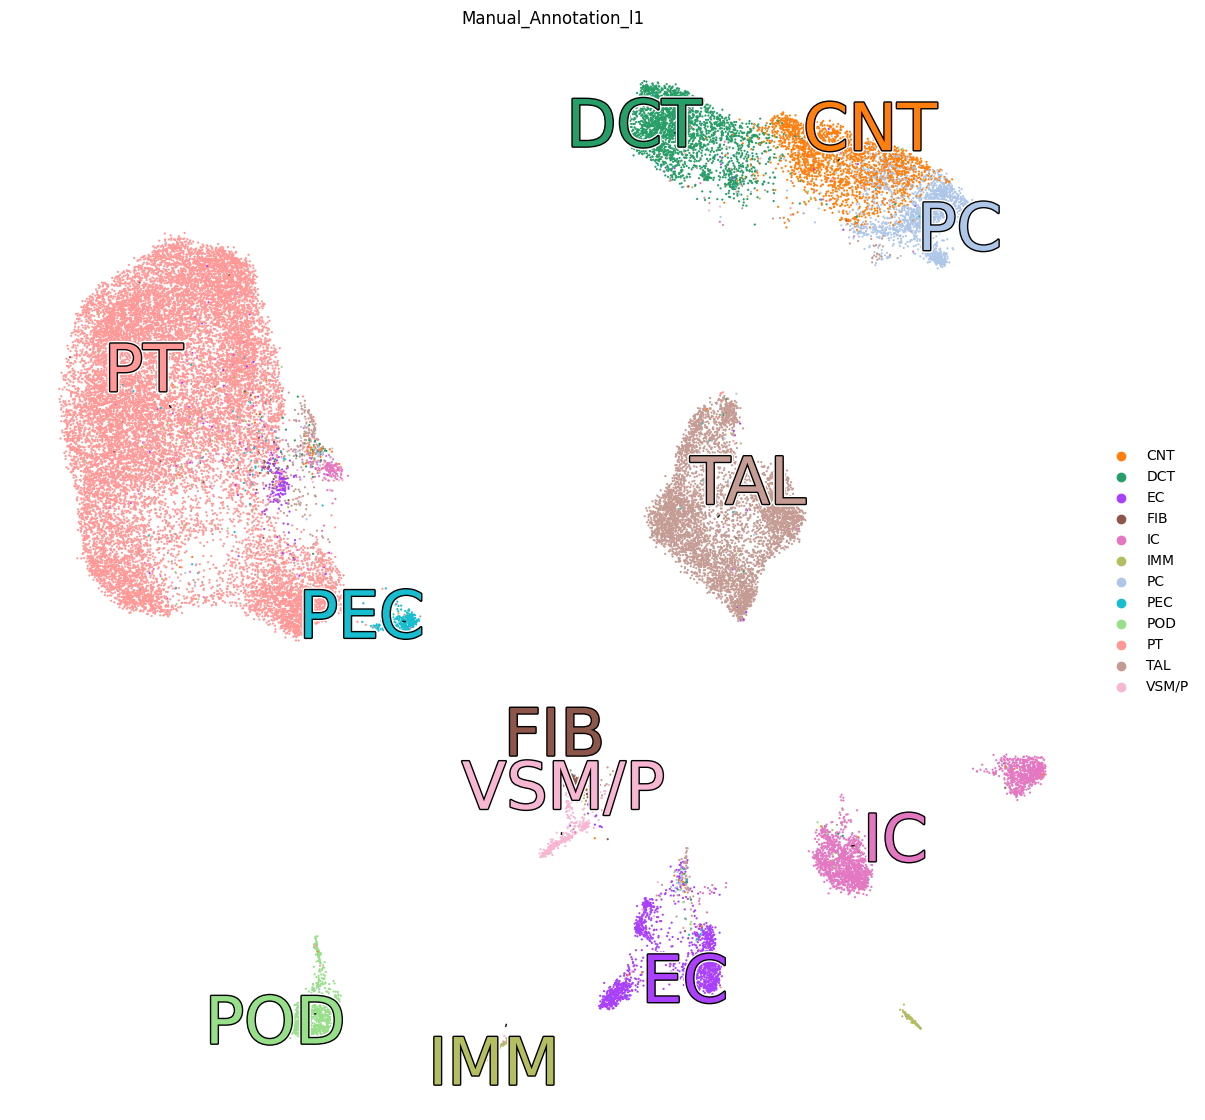

In [65]:
for latent in ['Seurat_WNN']:
    for ann in ['Manual_Annotation_l1']:
        mdata.uns[f'{ann}_colors'] = [l1_colors[i] for i in mdata.obs[ann].cat.categories]
        umap_refined(mdata,
                    umap = f'Umap_{latent}',
                    var = ann,
                    size= 10,
                    label_size = 45 * (50/len(mdata.obs[ann].unique())),
                    width_in_inches = 14,
                    height_in_inches = 14,
                    max_iterations=7)
        # plt.savefig(f'../DEEPSCORE/figures/umaps/{ann}.png',  bbox_inches='tight', dpi=300)
        plt.savefig(f'figures/UMAP_{ann}_{latent}.png',  bbox_inches='tight', dpi=300)

Figure size= (14, 14) dpi= 100.0 Scale factor = 49.29339874697772


/tmp/ipykernel_4503/858591446.py:88: RuntimeWarning: invalid value encountered in divide
  norm_direction = direction / np.linalg.norm(direction)


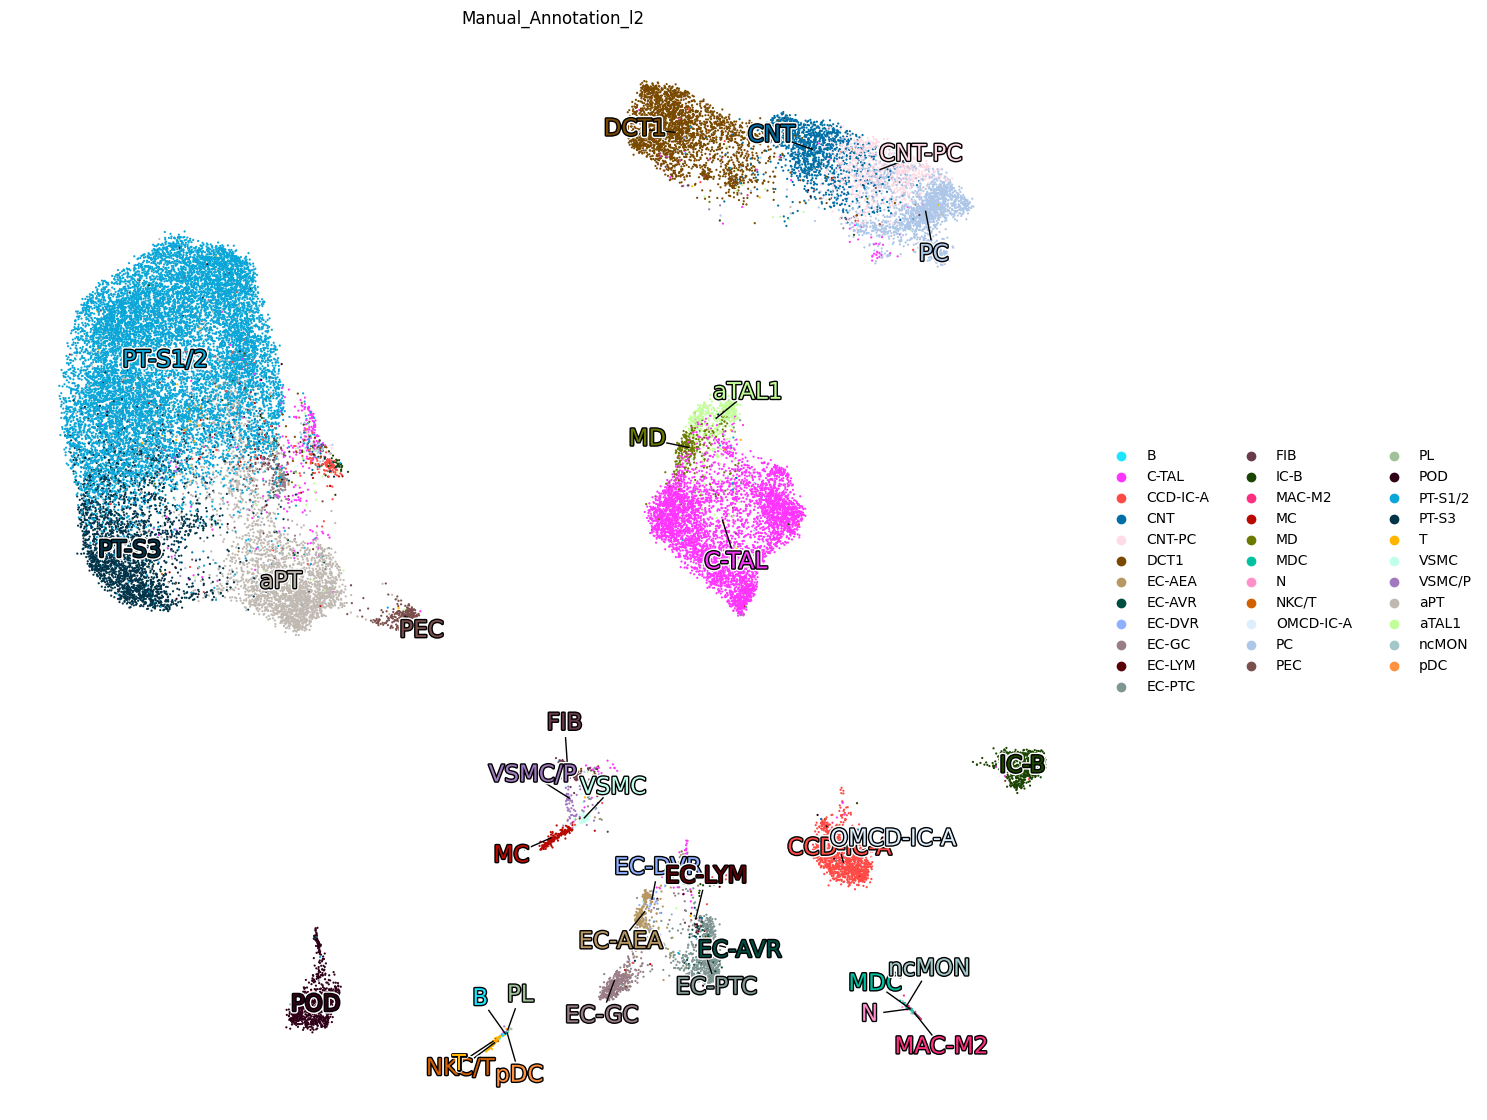

In [ ]:
for latent in ['Seurat_WNN']:
    for ann in ['Manual_Annotation_l2']:
        mdata.uns[f'{ann}_colors'] = [l3_colors[i] for i in mdata.obs[ann].cat.categories]
        umap_refined(mdata,
                    umap = f'Umap_{latent}',
                    var = ann,
                    size= 10,
                    label_size = 45 * (50/len(mdata.obs[ann].unique())),
                    width_in_inches = 14,
                    height_in_inches = 14,
                    max_iterations=7)
        # plt.savefig(f'../DEEPSCORE/figures/umaps/{ann}.png',  bbox_inches='tight', dpi=300)
        plt.savefig(f'figures/UMAP_{ann}_{latent}.png',  bbox_inches='tight', dpi=300)

/tmp/ipykernel_4503/2430896558.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rna['mod'] = 'RNA'
/tmp/ipykernel_4503/2430896558.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_atac['mod'] = 'ATAC'
/tmp/ipykernel_4503/2430896558.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_rna.groupby('

['EC', 'FIB', 'PEC', 'PT', 'IMM', 'VSM/P', 'POD', 'TAL', 'IC', 'CNT', 'PC', 'DCT']


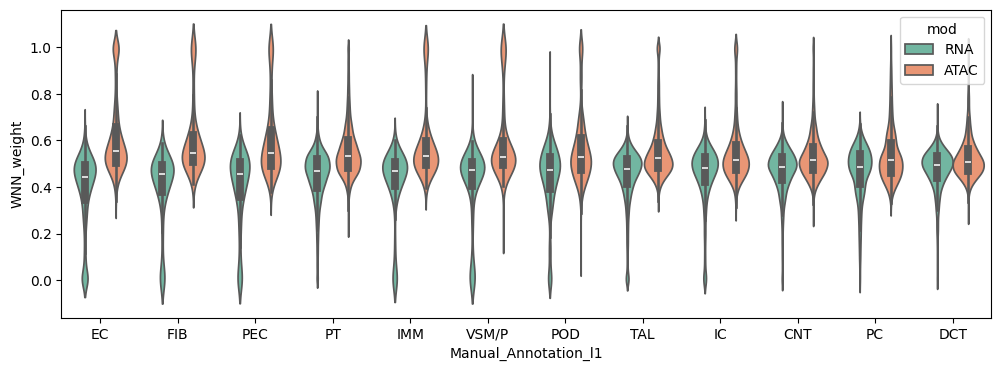

In [69]:
df_rna = mdata.obs[['WNN_rna_weights','Manual_Annotation_l1']]
df_rna.columns = ['WNN_weight','Manual_Annotation_l1']

df_rna['mod'] = 'RNA'
df_atac = mdata.obs[['WNN_atac_weights','Manual_Annotation_l1']]
df_atac.columns = ['WNN_weight','Manual_Annotation_l1']

df_atac['mod'] = 'ATAC'
df = pd.concat([df_rna,df_atac], axis = 0)
df

means = df_rna.groupby('Manual_Annotation_l1')['WNN_weight'].median()

# Sort the columns by mean values
sorted_cols = list(means.sort_values().index)
print(sorted_cols)
# Reorder the DataFrame according to sorted column indices
# sorted_df = df[sorted_cols]

rcParams['figure.figsize'] = (12,4)

sns.violinplot(y="WNN_weight", x="Manual_Annotation_l1",hue = 'mod', data = df,order = sorted_cols, palette ='Set2')
plt.savefig('figures/Violin_l1_Seurat_WNN_WEIGHTS.png', dpi = 300, bbox_inches='tight')

/tmp/ipykernel_4503/2531894693.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rna['mod'] = 'RNA'
/tmp/ipykernel_4503/2531894693.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_atac['mod'] = 'ATAC'
/tmp/ipykernel_4503/2531894693.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_rna.groupby('

['ncMON', 'EC-GC', 'EC-PTC', 'EC-DVR', 'T', 'VSMC', 'VSMC/P', 'FIB', 'PEC', 'MAC-M2', 'PT-S3', 'EC-AVR', 'PT-S1/2', 'aTAL1', 'aPT', 'POD', 'C-TAL', 'EC-AEA', 'MC', 'CNT', 'CCD-IC-A', 'IC-B', 'PC', 'CNT-PC', 'DCT1', 'MDC', 'NKC/T', 'N', 'PL', 'MD', 'OMCD-IC-A', 'EC-LYM', 'B', 'pDC']


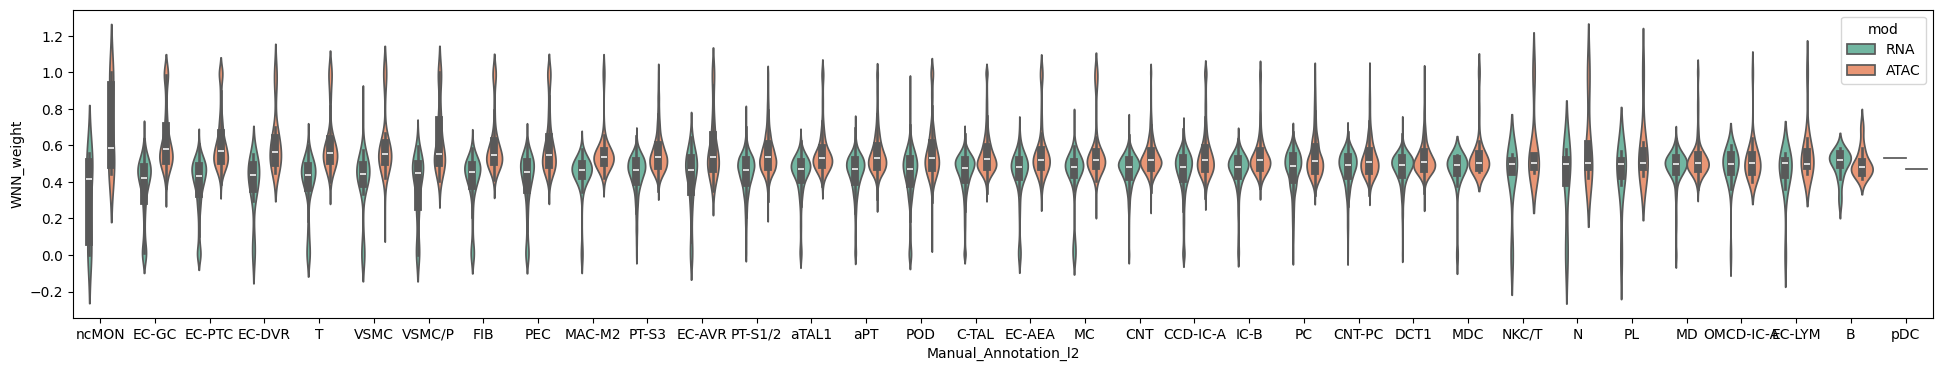

In [70]:
df_rna = mdata.obs[['WNN_rna_weights','Manual_Annotation_l2']]
df_rna.columns = ['WNN_weight','Manual_Annotation_l2']

df_rna['mod'] = 'RNA'
df_atac = mdata.obs[['WNN_atac_weights','Manual_Annotation_l2']]
df_atac.columns = ['WNN_weight','Manual_Annotation_l2']

df_atac['mod'] = 'ATAC'
df = pd.concat([df_rna,df_atac], axis = 0)
df

means = df_rna.groupby('Manual_Annotation_l2')['WNN_weight'].median()

# Sort the columns by mean values
sorted_cols = list(means.sort_values().index)
print(sorted_cols)
# Reorder the DataFrame according to sorted column indices
# sorted_df = df[sorted_cols]

rcParams['figure.figsize'] = (24,4)


sns.violinplot(y="WNN_weight", x="Manual_Annotation_l2",hue = 'mod', data = df,order = sorted_cols, palette ='Set2')
plt.savefig('figures/Violin_l2_Seurat_WNN_WEIGHTS.png', dpi = 300, bbox_inches='tight')